In [ ]:
! pip install mlflow==2.16.0

In [ ]:
! pip install pycaret[full]

In [ ]:
! pip install pandas numpy==1.26.4

In [58]:
! pip install pickleshare --force-reinstall

  Using cached pickleshare-0.7.5-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached pickleshare-0.7.5-py2.py3-none-any.whl (6.9 kB)
  Attempting uninstall: pickleshare
    Found existing installation: pickleshare 0.7.5
    Uninstalling pickleshare-0.7.5:
      Successfully uninstalled pickleshare-0.7.5


# Dependencies

In [1]:
import pycaret.regression as pcr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

import datetime

In [2]:
with open('202001-citibike-tripdata_1.csv', 'r') as file:
    df_base = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])

# Data Prep

In [3]:
for id in ["SYS036", "SYS035", "SYS033", "SYS016", "Lab - NYC"]:
    ids_to_drop = df_base[df_base['start_station_id'] == id].index
    df_base.drop(ids_to_drop, inplace=True)

In [4]:
# DROPPING DUPLICATES
df_base.drop_duplicates(inplace=True)

In [5]:
# DROPPING NULLS
df_base.dropna(inplace=True)

In [6]:
# PADRONIZING START_STATION_ID DATA TYPE (VERY IMPORTANT FOR PANDAS)
df_base['start_station_id'] = df_base['start_station_id'].astype(str).str.strip()

In [7]:
# EXTRACTING TIME-BASED FEATURES
df_base['day'] = df_base['started_at'].dt.day
df_base['hour'] = df_base['started_at'].dt.hour
df_base['weekday'] = df_base['started_at'].dt.dayofweek
df_base['is_weekend'] = df_base['weekday'] >= 5
df_base['trip_duration'] = (df_base['ended_at'] - df_base['started_at']).dt.total_seconds()

In [8]:
def faster_trip_distance(row):
  '''Faster distance calculation between coordinates pairs, uses Haversine formula.'''
  start_coords = (row['start_lat'], row['start_lng'])
  end_coords = (row['end_lat'], row['end_lng'])
  coords_1_rad = np.radians(start_coords)
  coords_1_rad = coords_1_rad.reshape(1, -1)  # Reshape to (1, 2)
  coords_2_rad = np.radians(end_coords)
  coords_2_rad = coords_2_rad.reshape(1, -1)

  earth_radius_km = 6371.0 # Earth's radius in kilometers
  distance_rad = haversine_distances(coords_1_rad, coords_2_rad)
  distance_km = distance_rad * earth_radius_km
  return distance_km[0][0]

In [9]:
df_base['trip_distance'] = df_base.apply(faster_trip_distance, axis=1)

In [10]:
df_base['is_member'] = df_base['member_casual'] == 'member'

In [11]:
# AGGREGATING BY DAY-HOUR FOR EACH STATION
df_agg = df_base.groupby(['start_station_id', 'day', 'hour', 'weekday', 'is_weekend']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
    avg_trip_duration=('trip_duration', 'mean'),  # Average of 'trip_duration'
    avg_trip_distance=('trip_distance', 'mean'),
    member_ratio=('is_member', 'mean'),
  ).reset_index()

In [39]:
df_agg

,start_station_id,day,hour,weekday,is_weekend,trip_amount,avg_trip_duration,avg_trip_distance,member_ratio
0,3460.01,1,10,2,False,2,4481.861500,4.941053,0.0
1,3460.01,2,11,3,False,1,4761.963000,6.947962,0.0
2,3460.01,2,14,3,False,3,1012.861333,2.241754,1.0
3,3460.01,2,15,3,False,1,1456.683000,3.646131,1.0
4,3460.01,2,17,3,False,1,1834.887000,4.394092,1.0
...,...,...,...,...,...,...,...,...,...
293860,7886.02,22,14,2,False,1,1652.468000,3.877983,1.0
293861,7886.02,22,15,2,False,2,1765.140000,4.916444,1.0
293862,7886.02,22,16,2,False,2,682.755000,1.729018,1.0
293863,7886.02,22,17,2,False,1,653.473000,1.283554,0.0


## Experimental Features

In [12]:
t = df_agg[df_agg['start_station_id'] == "3460.01"]

In [16]:
station_avg_hourly_trips = df_agg.groupby('start_station_id')['trip_amount'].mean().rename('avg_overall_hourly_trips')

In [18]:
off_peak = [h for h in range(24) if h not in [8, 17]]
df_off_peak = df_agg[df_agg['hour'].isin(off_peak)]
station_avg_offpeak = df_off_peak.groupby('start_station_id')['trip_amount'].mean().rename('avg_offpeak_hourly_trips')

In [21]:
df_weekdays = df_agg[df_agg['is_weekend'] == False]

avg_weekday_am = df_weekdays[df_weekdays['hour'] == 8].groupby('start_station_id')['trip_amount'].mean().rename('avg_weekday_am')
avg_weekday_pm = df_weekdays[df_weekdays['hour'] == 17].groupby('start_station_id')['trip_amount'].mean().rename('avg_weekday_pm')

In [23]:
station_features = pd.DataFrame(index=df_agg['start_station_id'].unique())
station_features = station_features.join(station_avg_hourly_trips)
station_features = station_features.join(station_avg_offpeak)
station_features = station_features.join(avg_weekday_am)
station_features = station_features.join(avg_weekday_pm)

station_features.fillna(0, inplace=True)

In [26]:
station_features['ratio_am_to_daily_avg'] = station_features['avg_weekday_am'] / station_features['avg_overall_hourly_trips']
station_features['ratio_pm_to_daily_avg'] = station_features['avg_weekday_pm'] / station_features['avg_overall_hourly_trips']
station_features['ratio_am_off_peak_avg'] = station_features['avg_weekday_am'] / station_features['avg_offpeak_hourly_trips']
station_features['ratio_pm_off_peak_avg'] = station_features['avg_weekday_pm'] / station_features['avg_offpeak_hourly_trips']

station_features.replace([np.inf, -np.inf], 0, inplace=True) # Handle division by zero if avg is 0

In [28]:
station_features = station_features.reset_index().rename(columns={"index":"start_station_id"})

In [29]:
df_agg = pd.merge(df_agg, station_features, on="start_station_id", how="left")

In [30]:
df_agg.columns

Index(['start_station_id', 'day', 'hour', 'weekday', 'is_weekend',
       'trip_amount', 'avg_trip_duration', 'avg_trip_distance', 'member_ratio',
       'avg_overall_hourly_trips', 'avg_offpeak_hourly_trips',
       'avg_weekday_am', 'avg_weekday_pm', 'ratio_am_to_daily_avg',
       'ratio_pm_to_daily_avg', 'ratio_am_off_peak_avg',
       'ratio_pm_off_peak_avg'],
      dtype='object')

# Training

In [31]:
# PYCARET SETUP
catboost_setup = pcr.setup(
    data=df_agg,
    target='trip_amount',
    categorical_features=['start_station_id', 'weekday', 'is_weekend'],
    numeric_features=[
        'avg_trip_duration', 
        'hour', 
        'avg_trip_distance', 
        'member_ratio', 
        'avg_overall_hourly_trips', 
        'avg_offpeak_hourly_trips',
        'avg_weekday_am', 
        'avg_weekday_pm', 
        'ratio_am_to_daily_avg',
        'ratio_pm_to_daily_avg', 
        'ratio_am_off_peak_avg',
        'ratio_pm_off_peak_avg'],
    ignore_features=['day'],
    verbose=True,
    session_id=321,
)

,Description,Value
0,Session id,321
1,Target,trip_amount
2,Target type,Regression
3,Original data shape,"(293865, 17)"
4,Transformed data shape,"(293865, 22)"
5,Transformed train set shape,"(205705, 22)"
6,Transformed test set shape,"(88160, 22)"
7,Ignore features,1
8,Numeric features,12
9,Categorical features,3


In [32]:
# TEST-TRAINING MODELS FOR COMPARISON WITH CATBOOST
models_comparison = pcr.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.1487,3.6575,1.9123,0.7691,0.3393,0.4667,7.6950
rf,Random Forest Regressor,1.1143,3.7160,1.9273,0.7654,0.3347,0.4545,19.2180
xgboost,Extreme Gradient Boosting,1.1807,3.9084,1.9768,0.7532,0.3461,0.4751,0.7820
lightgbm,Light Gradient Boosting Machine,1.1997,3.9716,1.9927,0.7493,0.3452,0.4852,0.6840
et,Extra Trees Regressor,1.1993,4.2498,2.0614,0.7316,0.3522,0.4751,26.7980
gbr,Gradient Boosting Regressor,1.4122,5.7638,2.4001,0.6366,0.3931,0.5848,7.4210
dt,Decision Tree Regressor,1.4094,7.2091,2.6846,0.5446,0.4521,0.5233,0.5910
lr,Linear Regression,2.0391,11.8965,3.4480,0.2503,0.5395,0.8996,2.5780
ridge,Ridge Regression,2.0391,11.8965,3.4480,0.2503,0.5395,0.8996,0.3000
br,Bayesian Ridge,2.0391,11.8964,3.4479,0.2503,0.5394,0.8995,0.4050


In [33]:
# TRAINING THE MODEL
catboost_model = pcr.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1398,3.5332,1.8797,0.7697,0.3381,0.4641
1,1.1540,3.6589,1.9128,0.7741,0.3407,0.4692
2,1.1597,3.7489,1.9362,0.7736,0.3412,0.4691
3,1.1615,3.7400,1.9339,0.7821,0.3390,0.4684
4,1.1540,3.7115,1.9265,0.7657,0.3401,0.4687
5,1.1582,3.7597,1.9390,0.7702,0.3411,0.4669
6,1.1363,3.5214,1.8765,0.7658,0.3360,0.4601
7,1.1517,3.7447,1.9351,0.7629,0.3388,0.4654
8,1.1294,3.4994,1.8707,0.7473,0.3407,0.4718


In [34]:
# TUNING THE MODEL
tuned_catboost = pcr.tune_model(catboost_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1297,3.4444,1.8559,0.7755,0.3343,0.4552
1,1.1426,3.5679,1.8889,0.7797,0.3369,0.4599
2,1.1487,3.7061,1.9251,0.7762,0.3370,0.4600
3,1.1580,3.6736,1.9167,0.7860,0.3366,0.4614
4,1.1430,3.6324,1.9059,0.7707,0.3370,0.4597
5,1.1496,3.7031,1.9243,0.7737,0.3383,0.4591
6,1.1277,3.4916,1.8686,0.7678,0.3336,0.4524
7,1.1429,3.6928,1.9217,0.7662,0.3355,0.4545
8,1.1121,3.4327,1.8528,0.7521,0.3357,0.4612


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
pcr.evaluate_model(catboost_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [35]:
prediction = pcr.predict_model(catboost_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.1539,3.7629,1.9398,0.7647,0.3389,0.4659


In [36]:
prediction['error'] = prediction['trip_amount'] - prediction['prediction_label']

In [37]:
prediction['abs_error'] = prediction['error'].abs()

In [52]:
prediction['absolute_percentage_error'] = (prediction['error'] / prediction['trip_amount']).abs()

# Exploration

In [38]:
def normalize(data_list):
    """Normalizes a list of numbers to the range [0, 1]."""
    arr = np.array(data_list, dtype=float) # Ensure float for division
    if arr.min() == arr.max(): # Handle case where all elements are the same
        return np.zeros_like(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

## Daily Trips

In [ ]:
daily_trips = prediction.groupby(['day']).agg(
    tpd=('trip_amount', 'count'),
  ).reset_index()
daily_trips['normalized'] = normalize(daily_trips['tpd'])

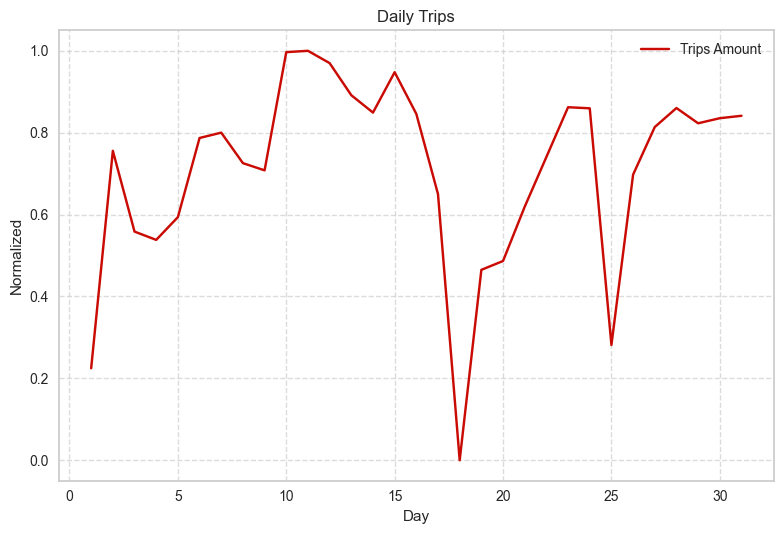

In [30]:
fig, ax = plt.subplots()
ax.plot(
    daily_trips['day'],
    daily_trips['normalized'],
    marker='x',
    linestyle='-',
    color='r',
    label='Trips Amount'
)

ax.set_xlabel('Day')
ax.set_ylabel('Normalized')
ax.set_title('Daily Trips')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Peak Analysis

In [53]:
p1 = prediction[['weekday', 'hour', 'trip_amount', 'absolute_percentage_error']]
p1['is_workday'] = p1['weekday'] >= 5

In [54]:
workday_trips = p1[p1['is_workday'] == False].groupby(['hour']).agg(
    tph=('trip_amount', 'count'),
    mape=('absolute_percentage_error', 'mean')
  ).reset_index()

weekend_trips = p1[p1['is_workday'] == True].groupby(['hour']).agg(
    tph=('trip_amount', 'count'),
    mape=('absolute_percentage_error', 'mean')
  ).reset_index()

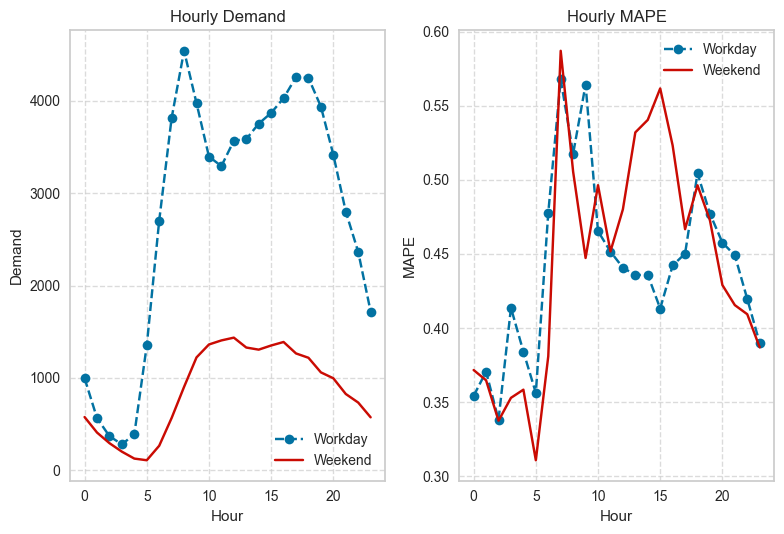

In [55]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(
    workday_trips['hour'],
    workday_trips['tph'],
    marker='o',
    linestyle='--',
    color='b',
    label='Workday'
)

ax[0].plot(
    weekend_trips['hour'],
    weekend_trips['tph'],
    marker='x',
    linestyle='-',
    color='r',
    label='Weekend'
)

ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Demand')
ax[0].set_title('Hourly Demand')
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(
    workday_trips['hour'],
    workday_trips['mape'],
    marker='o',
    linestyle='--',
    color='b',
    label='Workday'
)

ax[1].plot(
    weekend_trips['hour'],
    weekend_trips['mape'],
    marker='x',
    linestyle='-',
    color='r',
    label='Weekend'
)

ax[1].set_xlabel('Hour')
ax[1].set_ylabel('MAPE')
ax[1].set_title('Hourly MAPE')
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Error and Demand

In [56]:
hourly = prediction.groupby(['hour']).agg(
    mape=('absolute_percentage_error', 'mean'),
    tph=('trip_amount', 'count'),
    pph=('prediction_label', 'count'),
  ).reset_index()

for col in hourly.columns:
    hourly[col + "_normalized"] = normalize(hourly[col])

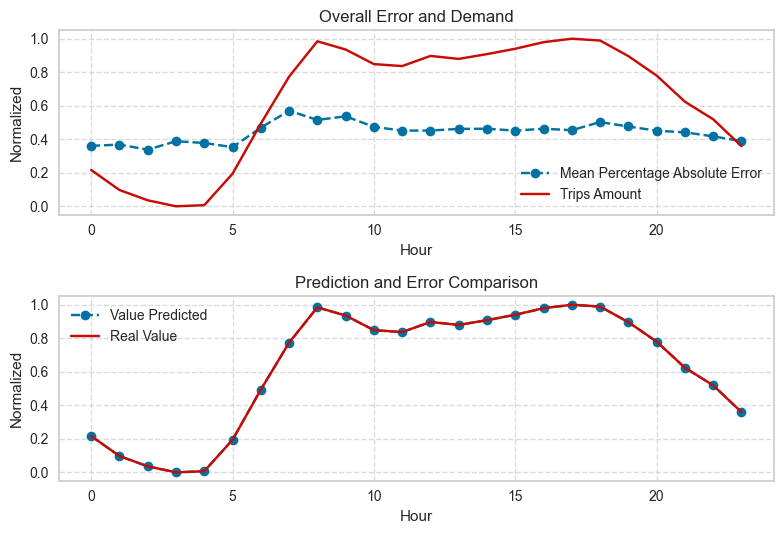

In [57]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(
    hourly['hour'],
    hourly['mape'],
    marker='o',
    linestyle='--',
    color='b',
    label='Mean Percentage Absolute Error'
)

ax[0].plot(
    hourly['hour'],
    hourly['tph_normalized'],
    marker='x',
    linestyle='-',
    color='r',
    label='Trips Amount'
)

ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Normalized')
ax[0].set_title('Overall Error and Demand')
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(
    hourly['hour'],
    hourly['pph_normalized'],
    marker='o',
    linestyle='--',
    color='b',
    label='Value Predicted'
)

ax[1].plot(
    hourly['hour'],
    hourly['tph_normalized'],
    marker='x',
    linestyle='-',
    color='r',
    label='Real Value'
)

ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Normalized')
ax[1].set_title('Prediction and Error Comparison')
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

## Peak Demand Stations

In [58]:
popularity_rank = prediction[prediction['hour'] == 8.0].groupby(['start_station_id', 'hour']).agg(
    mape=('absolute_percentage_error', 'mean'),
    hourly_trips=('trip_amount', 'sum'),
  ).reset_index()
popularity_rank = popularity_rank.sort_values('hourly_trips', ascending=False).reset_index()

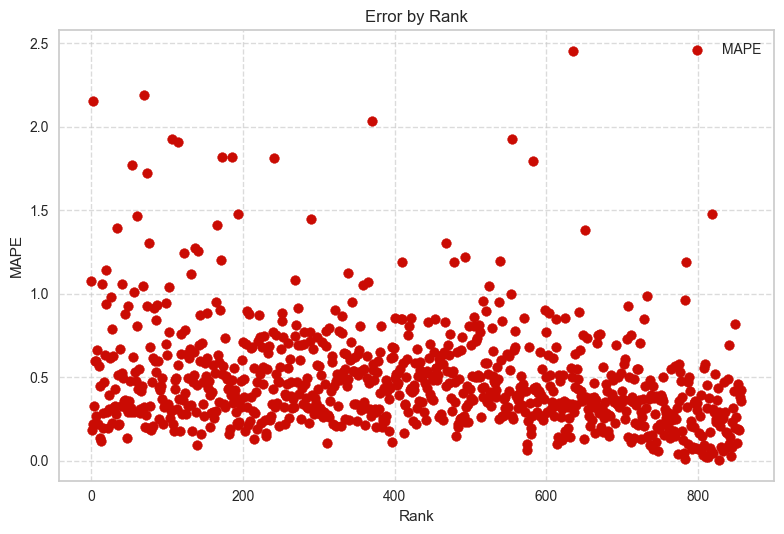

In [60]:
fig, ax = plt.subplots()
ax.scatter(
    popularity_rank.index,
    popularity_rank['mape'],
    marker='o',
    linestyle='-',
    color='r',
    label='MAPE'
)

ax.set_xlabel('Rank')
ax.set_ylabel('MAPE')
ax.set_title('Error by Rank')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()